<a href="https://colab.research.google.com/github/mkandaleft/COMP432-GroupM/blob/main/Comp432.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic includes.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.metrics
import torch
import torchvision
import random

# Do we need pandas, etc.?

# Use the GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/Users/ankitaingle/Desktop/Fall 2023/COMP 432-DD/Project/COMP432-GroupM/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


cpu


# Task 1

In [39]:
# Task specific includes.
import zipfile

# Download and unzip the first dataset.
!gdown 1ezX0lJaB8atZesMns4cGHR3pXkRTEKSt # Roxane: I put the dataset on my Drive for ease of downloading.

with zipfile.ZipFile("/content/Dataset1.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

data_path = "/content/Colorectal Cancer_"

Downloading...
From: https://drive.google.com/uc?id=1ezX0lJaB8atZesMns4cGHR3pXkRTEKSt
To: /content/Dataset1.zip
100% 814M/814M [00:04<00:00, 186MB/s]


In [40]:
# Load the data to a torch tensor.

# Code partly provided by the outline for assignment 1.
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Data normalization done here.
dataset = torchvision.datasets.ImageFolder(data_path, transforms) # Load the images and their labels into a tensor.

train_set, test_set = torch.utils.data.random_split(dataset, [0.7,0.3]) # Split the dataset into training and testing set.

batch_size = 100 # What batch size do we want?
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size)#, num_workers=2) # Create train loader. The multiple workers were being a fuck :/
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True)#, num_workers=2) # Create test loader.

torch.Size([3, 224, 224]) 1


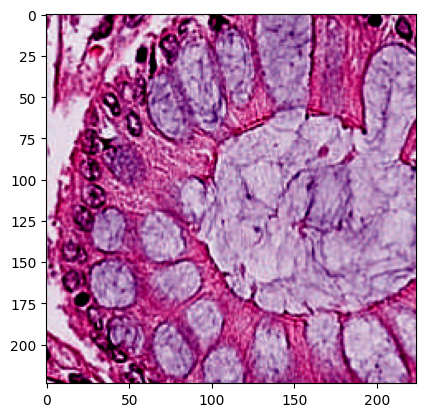

In [41]:
# Look at a random sample from the normalized training set.
index = random.randint(0, len(train_set))
image, label = train_set[index]
plt.imshow(image.numpy().transpose(1, 2, 0))
print(image.shape, label)

# Instead, print the same image before and after loading in the dataset?

# Preprocess the data.
# Do we need to do data augmentation?

In [42]:
## Declare the model
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

resnet18 = torchvision.models.resnet18() # Do we need any special parameters?
resnet18 = resnet18.to(device)

In [43]:
# Train the model with the dataset.

learning_rate = 0.0025
num_epoch = 20

loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(resnet18.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.001) # Customize other params?
#optimizer = torch.optim.Adam(resnet18.parameters(), lr = learning_rate) # Should we use adam instead of SGD? It didn't give good results when I tried.

next_epoch = 1
for epoch in range(next_epoch, next_epoch+num_epoch):
    resnet18.train()

    for i, batch in enumerate(train_loader, 0):
        X, y = batch

        X = X.to(device)
        y = y.to(device)

        y_pred = resnet18(X)
        loss = loss_function(y_pred, y)

        resnet18.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch %2d: loss on final training batch: %.4f" % (epoch, loss.item()))

next_epoch = epoch+1

Epoch  1: loss on final training batch: 0.4210
Epoch  2: loss on final training batch: 0.3562


KeyboardInterrupt: ignored

In [ ]:
# Save / Export the model and its weights.

torch.save(resnet18, "resnet18_model.pth")
torch.save(resnet18.state_dict(), "resnet18_weights.pth")

In [52]:
# Load the pre-trained moved.

checkpoint =  torch.load("/content/resnet18_weights.pth")

resnet18.load_state_dict(checkpoint)

<All keys matched successfully>

Classification report for the training set:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1419
           1       0.99      1.00      0.99      1377
           2       0.96      0.99      0.98      1404

    accuracy                           0.98      4200
   macro avg       0.98      0.98      0.98      4200
weighted avg       0.98      0.98      0.98      4200


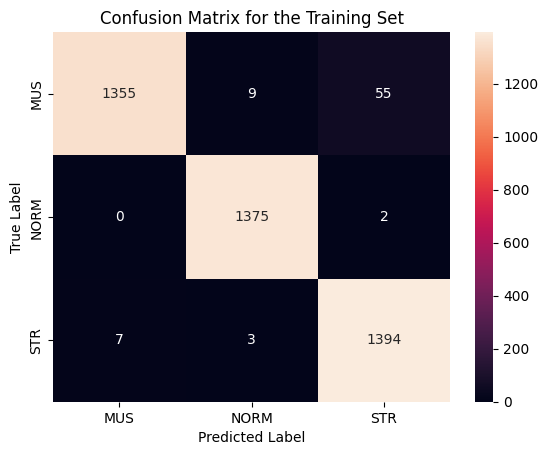


Classification report for the testing set:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       581
           1       0.99      1.00      1.00       623
           2       0.96      0.99      0.98       596

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800


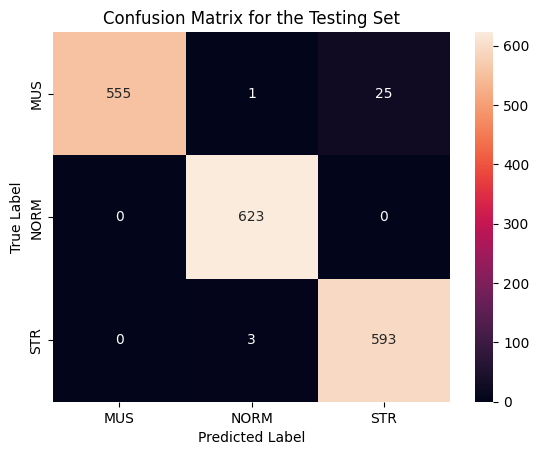

In [54]:
# Testing time!

# Roxane: I mostly copied the work I'd done for my assignment 1, so we'll likely need to modify this, have it print more info, etc.

resnet18.eval()

# Test and report on the training data.
y_train_true = []
y_train_pred = []

for data in train_loader:
  train_inputs, train_labels = data
  train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
  y_train_true.extend(train_labels.tolist())

  output = torch.softmax(resnet18(train_inputs), dim=1)
  y_train_pred.extend(output.argmax(dim=1).cpu().numpy().tolist())

class_report_train = sklearn.metrics.classification_report(y_train_true, y_train_pred)
print("Classification report for the training set:")
print(class_report_train)
#print("\nConfusion matrix for the training set:\nMUS, NORM, STR")
#print(sklearn.metrics.confusion_matrix(y_train_true, y_train_pred))

# Display the confusion matrix as a fancy picture.
class_labels = ["MUS", "NORM", "STR"]
cm_train = sklearn.metrics.confusion_matrix(y_train_true, y_train_pred)

sns.heatmap(cm_train, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for the Training Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Test and report on the testing data.
y_test_true = []
y_test_pred = []

for data in test_loader:
  test_inputs, test_labels = data
  test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
  y_test_true.extend(test_labels.tolist())

  output = torch.softmax(resnet18(test_inputs), dim=1)
  y_test_pred.extend(output.argmax(dim=1).cpu().numpy().tolist())

class_report_test = sklearn.metrics.classification_report(y_test_true, y_test_pred)
print("\nClassification report for the testing set:")
print(class_report_test)
#print("\nConfusion matrix for the testing set:\nMUS, NORM, STR")
#print(sklearn.metrics.confusion_matrix(y_test_true, y_test_pred))

# Display the confusion matrix as a fancy picture.
cm_test = sklearn.metrics.confusion_matrix(y_test_true, y_test_pred)

sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for the Testing Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.manifold import TSNE

resnet18.eval()

# Store features and labels
features_list = []
labels_list = []

# Get the features and labels
for data in train_loader:
    train_inputs, train_labels = data
    train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
    features = resnet18(train_inputs).detach().cpu().numpy()
    features_list.append(features)
    labels_list.append(train_labels.cpu().numpy())

# Concatenate features and labels
features = torch.from_numpy(np.concatenate(features_list))
labels = torch.from_numpy(np.concatenate(labels_list))

# Reshape the features tensor if needed
features = features.view(features.size(0), -1)  # Reshape if necessary for t-SNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
embedded_features = tsne.fit_transform(features)

# Verbal class labels.
class_labels =["Smooth Muscle", "Normal Colon Mucosa", "Cancer-Associated Stroma"]

# Plot the t-SNE embedded features with class labels
plt.figure(figsize=(10, 8))
for class_idx in range(3):
    plt.scatter(
        embedded_features[labels == class_idx, 0],
        embedded_features[labels == class_idx, 1],
        label=class_labels[ class_idx],
    ) # How to switch the labels to "mus", "norm" and "str"?
plt.title('t-SNE Visualization of ResNet-18 Features')
plt.legend()
plt.show()

# Task 2

### Analyze and visualize feature extraction done by pre-trained CNN encoder from Task 1 when applied to Dataset 2 and Dataset 3

#### Dataset 2

In [53]:
# Create a folder 'content' in root and add Dataset 2 and Dataset 3 folders

# Download Dataset 2
data_path_2 = 'content/Dataset 2/Prostate Cancer'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
dataset_2 = torchvision.datasets.ImageFolder(data_path_2, transforms)

batch_size = 100
data_loader_2 = torch.utils.data.DataLoader(dataset_2, shuffle=True, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 300, 300]) 1


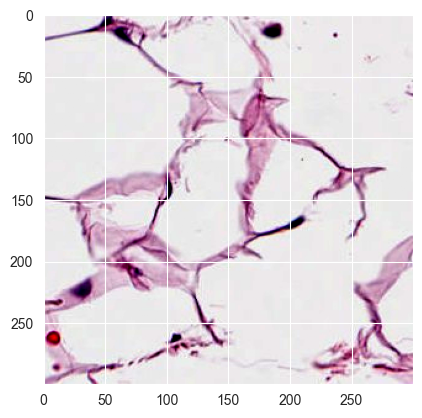

In [56]:
# Visualize a random sample from the normalized dataset
index = random.randint(0, len(dataset_2))
image, label = dataset_2[index]
plt.imshow(image.numpy().transpose(1, 2, 0))
print(image.shape, label)

In [57]:
# Load the pre-trained ResNet-18 CNN model trained in Task 1
checkpoint =  torch.load("resnet18_weights.pth", map_location=torch.device('cpu'))
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.load_state_dict(checkpoint)

/Users/ankitaingle/Desktop/Fall 2023/COMP 432-DD/Project/COMP432-GroupM/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ankitaingle/Desktop/Fall 2023/COMP 432-DD/Project/COMP432-GroupM/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>


Classification report for Dataset 2:
              precision    recall  f1-score   support

           0       0.39      0.54      0.45      2000
           1       0.14      0.22      0.17      2000
           2       0.00      0.00      0.00      2000

    accuracy                           0.25      6000
   macro avg       0.17      0.25      0.21      6000
weighted avg       0.17      0.25      0.21      6000


/Users/ankitaingle/Desktop/Fall 2023/COMP 432-DD/Project/COMP432-GroupM/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ankitaingle/Desktop/Fall 2023/COMP 432-DD/Project/COMP432-GroupM/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ankitaingle/Desktop/Fall 2023/COMP 432-DD/Project/COMP432-GroupM/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no

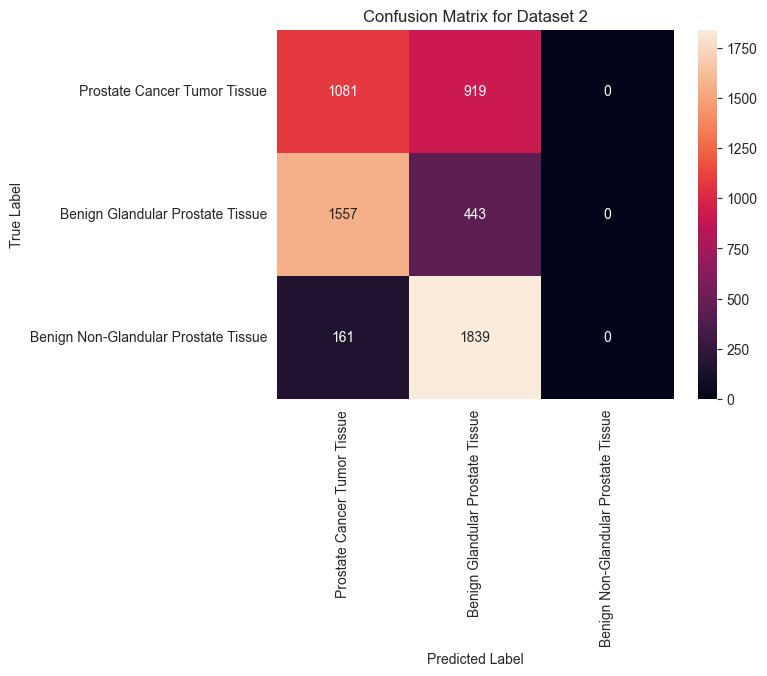

In [58]:
resnet18.eval()

y_true = []
y_pred = []

for data in data_loader_2:
  inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)
  y_true.extend(labels.tolist())

  output = torch.softmax(resnet18(inputs), dim=1)
  y_pred.extend(output.argmax(dim=1).cpu().numpy().tolist())

class_report_test = sklearn.metrics.classification_report(y_true, y_pred)
print("\nClassification report for Dataset 2:")
print(class_report_test)

# Display the confusion matrix for Dataset 2
class_labels = ["Prostate Cancer Tumor Tissue", "Benign Glandular Prostate Tissue", "Benign Non-Glandular Prostate Tissue"]

cm_test = sklearn.metrics.confusion_matrix(y_true, y_pred)

sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for Dataset 2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Dataset 3

In [59]:
# Download Dataset 3
data_path_3 = 'content/Dataset 3/Animal Faces'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
dataset_3 = torchvision.datasets.ImageFolder(data_path_3, transforms)

batch_size = 100
data_loader_3 = torch.utils.data.DataLoader(dataset_3, shuffle=True, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) 0


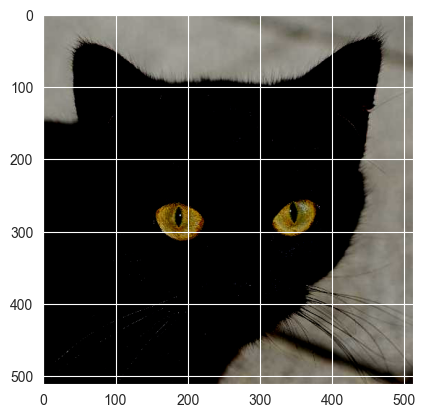

In [65]:
# Visualize a random sample from the normalized dataset
index = random.randint(0, len(dataset_3))
image, label = dataset_3[index]
plt.imshow(image.numpy().transpose(1, 2, 0))
print(image.shape, label)

/Users/ankitaingle/Desktop/Fall 2023/COMP 432-DD/Project/COMP432-GroupM/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ankitaingle/Desktop/Fall 2023/COMP 432-DD/Project/COMP432-GroupM/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ankitaingle/Desktop/Fall 2023/COMP 432-DD/Project/COMP432-GroupM/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no


Classification report for Dataset 3:
              precision    recall  f1-score   support

           0       0.36      0.34      0.35      2000
           1       0.29      0.60      0.39      2000
           2       0.00      0.00      0.00      2000

    accuracy                           0.32      6000
   macro avg       0.22      0.32      0.25      6000
weighted avg       0.22      0.32      0.25      6000


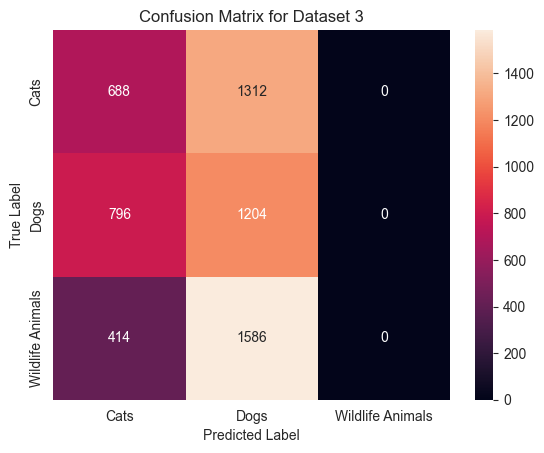

In [68]:
resnet18.eval()

y_true = []
y_pred = []

for data in data_loader_3:
  inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)
  y_true.extend(labels.tolist())

  output = torch.softmax(resnet18(inputs), dim=1)
  y_pred.extend(output.argmax(dim=1).cpu().numpy().tolist())

class_report_test = sklearn.metrics.classification_report(y_true, y_pred)
print("\nClassification report for Dataset 3:")
print(class_report_test)

# Display the confusion matrix for Dataset 3
class_labels = ["Cats", "Dogs", "Wildlife Animals"]

cm_test = sklearn.metrics.confusion_matrix(y_true, y_pred)

sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for Dataset 3")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()